# DQN Agent for Atari Games

This notebook implements a Deep Q-Network (DQN) agent to play Atari games using Stable Baselines 3 and Gymnasium. We'll cover:

1. Setting up the environment
2. Training a DQN agent
3. Evaluating the trained agent
4. Comparing different policies (MLP vs CNN)
5. Hyperparameter tuning experiments

## 1. Setup and Imports

First, let's install the required dependencies if they're not already installed.

In [ ]:
# Install required packages
!pip install "gymnasium[atari]" "stable-baselines3[extra]>=2.0.0" numpy opencv-python matplotlib

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from IPython.display import clear_output

# Create directories for logs and models
os.makedirs("logs", exist_ok=True)
os.makedirs("tensorboard_logs", exist_ok=True)

## 2. Define Helper Functions and Classes

Let's define a callback to track training progress and some helper functions for visualization.

In [2]:
class TrainingCallback(BaseCallback):
    """Custom callback for tracking training progress."""
    
    def __init__(self, verbose=0, plot_interval=10):
        super().__init__(verbose)
        self.rewards = []
        self.episode_lengths = []
        self.plot_interval = plot_interval
        
    def _on_step(self):
        if self.locals.get('dones')[0]:
            info = self.locals.get('infos')[0]
            if 'episode' in info:
                self.rewards.append(info['episode']['r'])
                self.episode_lengths.append(info['episode']['l'])
                
                if len(self.rewards) % self.plot_interval == 0:
                    avg_reward = np.mean(self.rewards[-self.plot_interval:])
                    avg_length = np.mean(self.episode_lengths[-self.plot_interval:])
                    print(f"Episode: {len(self.rewards)}")
                    print(f"Average reward over last {self.plot_interval} episodes: {avg_reward:.2f}")
                    print(f"Average episode length over last {self.plot_interval} episodes: {avg_length:.2f}")
                    print("-" * 50)
                    
                    # Plot training progress
                    if len(self.rewards) >= 20:  # Only plot after collecting enough data
                        self.plot_training_progress()
        return True
    
    def plot_training_progress(self):
        """Plot the training progress."""
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot rewards
        ax1.plot(self.rewards)
        ax1.set_title('Episode Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        
        # Plot moving average of rewards
        window_size = min(20, len(self.rewards))
        moving_avg = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(range(window_size-1, len(self.rewards)), moving_avg, 'r-', label=f'{window_size}-episode moving average')
        ax1.legend()
        
        # Plot episode lengths
        ax2.plot(self.episode_lengths)
        ax2.set_title('Episode Lengths')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Length')
        
        plt.tight_layout()
        plt.show()

## 3. Environment Setup

Let's set up the Atari environment with proper wrappers. We'll add error handling to ensure the environment is created correctly.

In [3]:
# First, let's check if Atari environments are available
try:
    # Try to import the Atari wrapper
    from stable_baselines3.common.atari_wrappers import AtariWrapper
    print("Atari wrappers imported successfully")
except ImportError:
    print("Error: Could not import AtariWrapper. Make sure gymnasium[atari] is installed correctly.")

Atari wrappers imported successfully


In [4]:
def create_environment(env_id="BreakoutNoFrameskip-v4", render_mode=None):
    """Create and wrap an Atari environment with error handling."""
    import ale_py
    try:
        # Try to create the environment
        env = gym.make(env_id, render_mode=render_mode)
        
        # Apply AtariWrapper
        from stable_baselines3.common.atari_wrappers import AtariWrapper
        env = AtariWrapper(env)
        
        return env
    except Exception as e:
        print(f"Error creating environment {env_id}: {e}")
        print("\nTrying to list available Atari environments:")
        try:
            # List available environments
            all_envs = gym.envs.registry.keys()
            atari_envs = [env for env in all_envs if 'ALE' in env or 'NoFrameskip' in env]
            if atari_envs:
                print(f"Available Atari environments: {atari_envs[:5]} ... (and {len(atari_envs)-5} more)")
                print(f"\nTry using one of these instead of {env_id}")
            else:
                print("No Atari environments found. Make sure you have installed gymnasium[atari,accept-rom-license]")
        except Exception as list_error:
            print(f"Error listing environments: {list_error}")
        
        # Return a simple CartPole environment as fallback
        print("\nFalling back to CartPole-v1 environment for demonstration purposes")
        return gym.make("CartPole-v1", render_mode=render_mode)

In [5]:
# Try to create the environment with error handling
env_id = "BreakoutNoFrameskip-v4"
env = create_environment(env_id)

# Display environment information
print(f"Environment: {env_id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment: BreakoutNoFrameskip-v4
Observation space: Box(0, 255, (84, 84, 1), uint8)
Action space: Discrete(4)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


## 4. Training a DQN Agent

Now let's train a DQN agent with a CNN policy.

In [41]:
def train_agent(env, policy_type="CnnPolicy", hyperparams=None, timesteps=1000000, experiment_name="default"):
    """Train a DQN agent with the specified policy and hyperparameters."""
    # Create log directory
    log_dir = f"logs/{experiment_name}"
    os.makedirs(log_dir, exist_ok=True)
    
    # Wrap environment with Monitor
    env = Monitor(env, log_dir)
    
    # Default hyperparameters
    default_params = {
        "learning_rate": 1e-4,
        "buffer_size": 500000,
        "learning_starts": 10000,
        "batch_size": 32,
        "gamma": 0.99,
        "exploration_fraction": 0.1,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "train_freq": 8,
        "gradient_steps": 2,
        "target_update_interval": 2000,
    }
    
    # Update with provided hyperparameters
    if hyperparams:
        default_params.update(hyperparams)
    
    print(f"Training DQN agent with {policy_type} policy")
    print(f"Hyperparameters: {default_params}")
    
    # Create the DQN agent
    model = DQN(
        policy_type, 
        env, 
        verbose=1,
        tensorboard_log=f"./tensorboard_logs/{experiment_name}/",
        **default_params
    )
    
    # Create callback
    callback = TrainingCallback(plot_interval=10)
    
    # Train the agent
    model.learn(total_timesteps=timesteps, callback=callback)
    
    # Save the trained model
    model_path = f"dqn_model_{experiment_name}"
    model.save(model_path)
    print(f"Model saved as {model_path}.zip")
    
    # Print final training statistics
    final_stats = {}
    if callback.rewards:
        avg_reward = np.mean(callback.rewards[-100:]) if len(callback.rewards) >= 100 else np.mean(callback.rewards)
        avg_length = np.mean(callback.episode_lengths[-100:]) if len(callback.episode_lengths) >= 100 else np.mean(callback.episode_lengths)
        print(f"Final training statistics:")
        print(f"Total episodes: {len(callback.rewards)}")
        print(f"Average reward over last 100 episodes: {avg_reward:.2f}")
        print(f"Average episode length over last 100 episodes: {avg_length:.2f}")
        
        final_stats = {
            "avg_reward": avg_reward,
            "avg_length": avg_length,
            "total_episodes": len(callback.rewards),
            "rewards": callback.rewards,
            "episode_lengths": callback.episode_lengths
        }
    
    return model, final_stats

### Train the DQN Agent

Now let's train our agent. You can adjust the number of timesteps based on your computational resources.

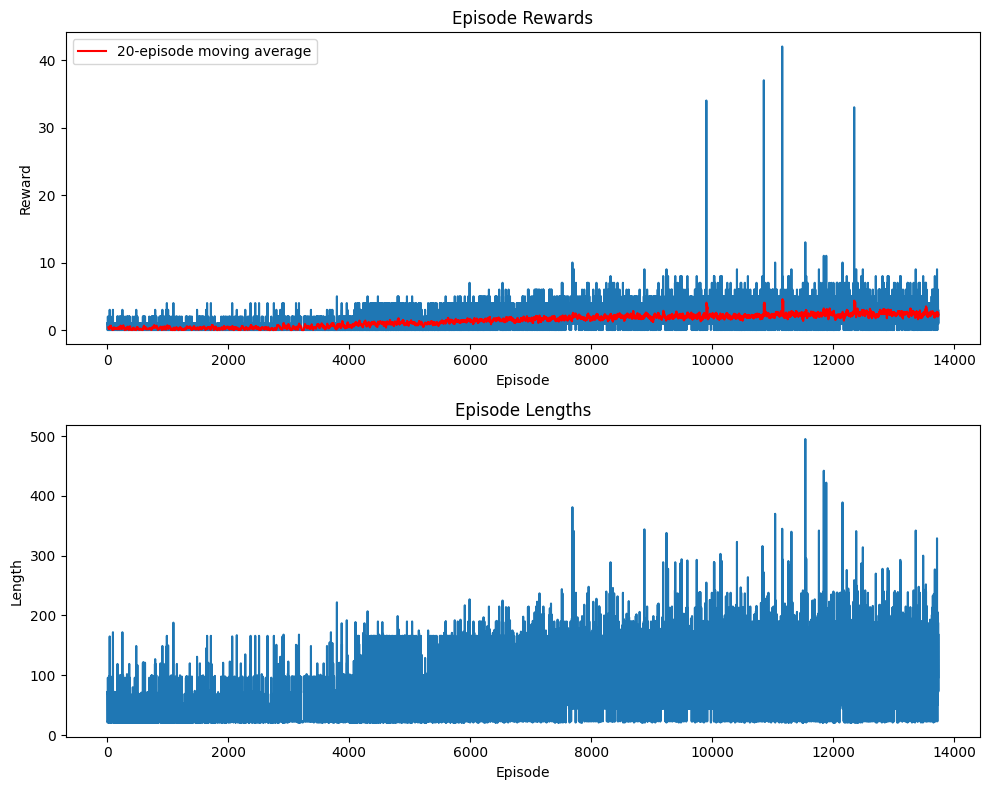

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13740    |
|    fps              | 161      |
|    time_elapsed     | 6192     |
|    total_timesteps  | 999154   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00955  |
|    n_updates        | 247288   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13744    |
|    fps              | 161      |
|    time_elapsed     | 6194     |
|    total_timesteps  | 999513   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00912  |
|    n_updates      

In [42]:
# Create a fresh environment
env = create_environment(env_id)

# Check if we're using CartPole (fallback) or an Atari environment
is_atari = 'ALE' in str(env) or 'NoFrameskip' in env_id
policy_type = "CnnPolicy" if is_atari else "MlpPolicy"

print(f"Using {policy_type} for environment {env_id}")

# Train the agent (adjust timesteps as needed)
model, training_stats = train_agent(
    env, 
    policy_type=policy_type, 
    # timesteps=50000,  # Reduced for demonstration, increase for better performance
    experiment_name="default_run"
)

## 5. Evaluating the Trained Agent

Let's evaluate our trained agent by watching it play.

In [43]:
def evaluate_agent(model, env_id, num_episodes=5, render_mode="human"):
    """Evaluate a trained agent."""
    try:
        # Create environment with rendering
        env = create_environment(env_id, render_mode=render_mode)
        
        rewards = []
        episode_lengths = []
        
        for episode in range(num_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False
            
            print(f"Starting episode {episode+1}/{num_episodes}")
            
            while not (done or truncated):
                # Get action from the trained model
                action, _ = model.predict(obs, deterministic=True)
                
                # Execute action in the environment
                obs, reward, done, truncated, info = env.step(action)
                
                # Update episode statistics
                episode_reward += reward
                episode_length += 1
                
                # Slow down rendering to make it viewable
                if render_mode == "human":
                    time.sleep(0.01)
            
            rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            
            print(f"Episode {episode+1} finished with reward: {episode_reward}, length: {episode_length}")
        
        # Print evaluation statistics
        print("\nEvaluation Results:")
        print(f"Average reward over {num_episodes} episodes: {np.mean(rewards):.2f}")
        print(f"Average episode length: {np.mean(episode_lengths):.2f}")
        print(f"Rewards per episode: {rewards}")
        
        env.close()
        return rewards, episode_lengths
    
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print("Falling back to non-rendering evaluation")
        
        # Try again without rendering
        if render_mode == "human":
            return evaluate_agent(model, env_id, num_episodes, render_mode=None)
        return [], []

In [44]:
# Evaluate the trained agent
# Note: This will try to open a window to display the game
# If running in an environment without display capabilities, it will fall back to non-rendering evaluation
rewards, lengths = evaluate_agent(model, env_id, num_episodes=20)

Starting episode 1/20
Episode 1 finished with reward: 2.0, length: 82
Starting episode 2/20
Episode 2 finished with reward: 2.0, length: 101
Starting episode 3/20
Episode 3 finished with reward: 2.0, length: 84
Starting episode 4/20
Episode 4 finished with reward: 4.0, length: 142
Starting episode 5/20
Episode 5 finished with reward: 3.0, length: 94
Starting episode 6/20
Episode 6 finished with reward: 2.0, length: 82
Starting episode 7/20
Episode 7 finished with reward: 2.0, length: 101
Starting episode 8/20
Episode 8 finished with reward: 2.0, length: 84
Starting episode 9/20
Episode 9 finished with reward: 4.0, length: 142
Starting episode 10/20
Episode 10 finished with reward: 3.0, length: 94
Starting episode 11/20
Episode 11 finished with reward: 4.0, length: 168
Starting episode 12/20
Episode 12 finished with reward: 5.0, length: 160
Starting episode 13/20
Episode 13 finished with reward: 2.0, length: 85
Starting episode 14/20
Episode 14 finished with reward: 2.0, length: 87
Star

## 6. Policy Comparison: MLP vs CNN

Let's compare the performance of MLP and CNN policies.

In [10]:
def compare_policies(env_id, timesteps=50000):
    """Compare MLP and CNN policies."""
    # Check if we're using an Atari environment
    try:
        env = create_environment(env_id)
        is_atari = 'ALE' in str(env) or 'NoFrameskip' in env_id
        env.close()
    except:
        is_atari = False
    
    # If not Atari, we'll compare different policies for CartPole
    if not is_atari:
        print(f"Environment {env_id} is not an Atari environment.")
        print("Using CartPole-v1 for policy comparison instead.")
        env_id = "CartPole-v1"
    
    policies = ["MlpPolicy", "CnnPolicy"] if is_atari else ["MlpPolicy"]
    results = {}
    
    for policy in policies:
        print(f"\n{'='*50}")
        print(f"Training with {policy}")
        print(f"{'='*50}\n")
        
        # Create fresh environment
        env = create_environment(env_id)
        
        # Train agent with this policy
        try:
            _, stats = train_agent(
                env, 
                policy_type=policy, 
                timesteps=timesteps,
                experiment_name=f"{policy.lower()}_comparison"
            )
            
            results[policy] = stats
        except Exception as e:
            print(f"Error training with {policy}: {e}")
            results[policy] = {"error": str(e)}
        
        env.close()
    
    # Compare results
    print("\n\n" + "="*60)
    print("POLICY COMPARISON RESULTS")
    print("="*60)
    print(f"{'Policy':<15} | {'Avg Reward':<15} | {'Avg Episode Length':<20} | {'Total Episodes':<15}")
    print("-"*60)
    
    for policy, stats in results.items():
        if "error" in stats:
            print(f"{policy:<15} | Error: {stats['error']}")
        else:
            print(f"{policy:<15} | {stats.get('avg_reward', 'N/A'):<15.2f} | {stats.get('avg_length', 'N/A'):<20.2f} | {stats.get('total_episodes', 'N/A'):<15}")
    
    # Plot comparison if we have valid results
    valid_results = {p: s for p, s in results.items() if "error" not in s and "rewards" in s}
    if valid_results:
        plt.figure(figsize=(12, 6))
        
        for policy, stats in valid_results.items():
            plt.plot(stats['rewards'], label=f"{policy} rewards")
        
        plt.title('Reward Comparison: Different Policies')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return results

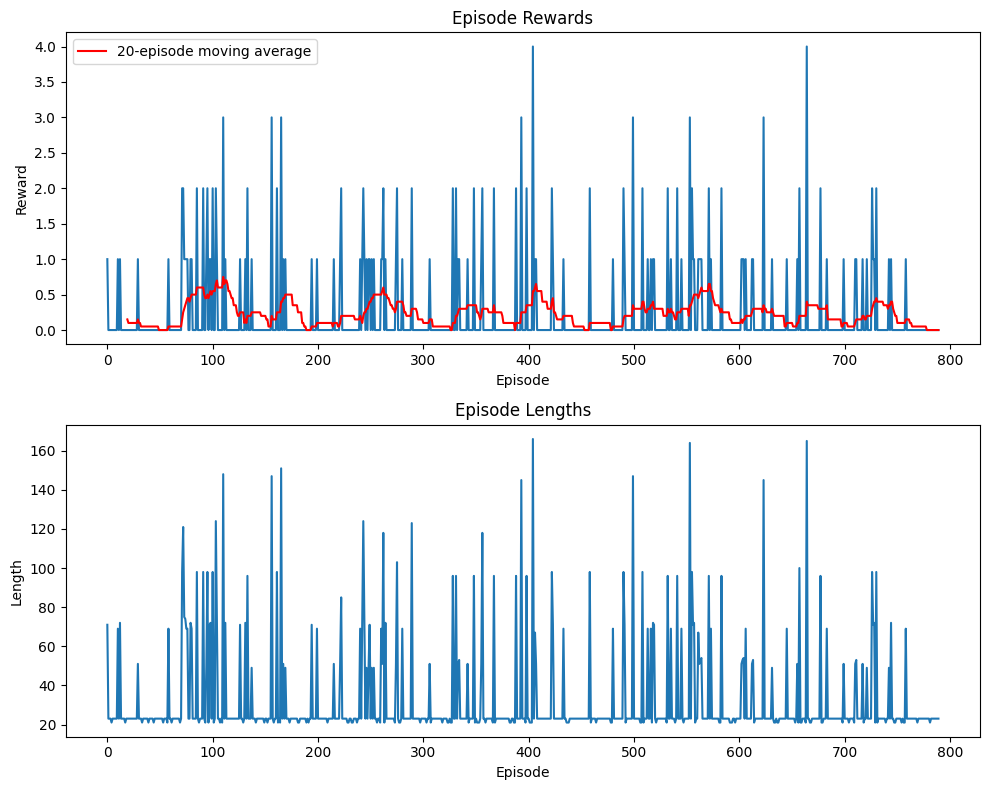

Model saved as dqn_model_cnnpolicy_comparison.zip
Final training statistics:
Total episodes: 790
Average reward over last 100 episodes: 0.14
Average episode length over last 100 episodes: 27.80


POLICY COMPARISON RESULTS
Policy          | Avg Reward      | Avg Episode Length   | Total Episodes 
------------------------------------------------------------
MlpPolicy       | 0.21            | 30.79                | 756            
CnnPolicy       | 0.14            | 27.80                | 790            


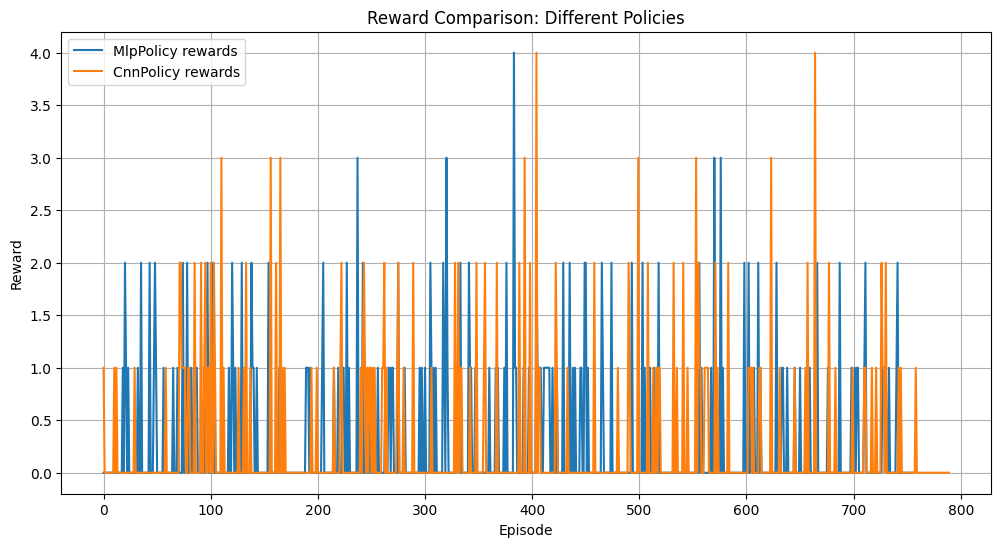

In [11]:
# Compare MLP and CNN policies
# Note: This will take some time to run
policy_results = compare_policies(env_id, timesteps=25000)

## 7. Hyperparameter Tuning

Let's experiment with different hyperparameter configurations.

In [45]:
def hyperparameter_tuning(env_id, timesteps=25000):
    """Test different hyperparameter configurations."""
    # Check if we're using an Atari environment
    try:
        env = create_environment(env_id)
        is_atari = 'ALE' in str(env) or 'NoFrameskip' in env_id
        env.close()
    except:
        is_atari = False
    
    # If not Atari, we'll use CartPole
    if not is_atari:
        print(f"Environment {env_id} is not an Atari environment.")
        print("Using CartPole-v1 for hyperparameter tuning instead.")
        env_id = "CartPole-v1"
    
    # Choose appropriate policy type
    policy_type = "CnnPolicy" if is_atari else "MlpPolicy"
    
    # Define hyperparameter sets to test
    hyperparameter_sets = [
        {
            "name": "default",
            "params": {
                "learning_rate": 1e-4,
                "batch_size": 32,
                "gamma": 0.99,
                "exploration_fraction": 0.1,
                "exploration_initial_eps": 1.0,
                "exploration_final_eps": 0.05,
            }
        },
        {
            "name": "high_lr",
            "params": {
                "learning_rate": 5e-4,  # Higher learning rate
                "batch_size": 32,
                "gamma": 0.99,
                "exploration_fraction": 0.1,
                "exploration_initial_eps": 1.0,
                "exploration_final_eps": 0.05,
            }
        },
        {
            "name": "high_gamma",
            "params": {
                "learning_rate": 1e-4,
                "batch_size": 32,
                "gamma": 0.995,  # Higher discount factor
                "exploration_fraction": 0.1,
                "exploration_initial_eps": 1.0,
                "exploration_final_eps": 0.05,
            }
        }
    ]
    
    # Train with each hyperparameter set and collect results
    results = []
    for hp_set in hyperparameter_sets:
        print(f"\n{'='*50}")
        print(f"Starting experiment: {hp_set['name']}")
        print(f"{'='*50}\n")
        
        # Create fresh environment
        env = create_environment(env_id)
        
        # Train with these hyperparameters
        try:
            _, stats = train_agent(
                env, 
                policy_type=policy_type,
                hyperparams=hp_set["params"], 
                timesteps=timesteps,
                experiment_name=hp_set["name"]
            )
            
            results.append({
                "name": hp_set["name"],
                "hyperparams": hp_set["params"],
                "stats": stats
            })
        except Exception as e:
            print(f"Error training with {hp_set['name']}: {e}")
            results.append({
                "name": hp_set["name"],
                "hyperparams": hp_set["params"],
                "error": str(e)
            })
        
        env.close()
    
    # Print summary of all experiments
    print("\n\n" + "="*80)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*80)
    print(f"{'Experiment':<15} | {'Learning Rate':<15} | {'Gamma':<8} | {'Batch Size':<10} | {'Avg Reward':<15}")
    print("-"*80)
    
    for result in results:
        hp = result["hyperparams"]
        if "error" in result:
            print(f"{result['name']:<15} | {hp['learning_rate']:<15.6f} | {hp['gamma']:<8.3f} | {hp['batch_size']:<10} | Error: {result['error']}")
        else:
            stats = result["stats"]
            print(f"{result['name']:<15} | {hp['learning_rate']:<15.6f} | {hp['gamma']:<8.3f} | {hp['batch_size']:<10} | {stats.get('avg_reward', 'N/A'):<15.2f}")
    
    # Create a table for the report
    print("\nHyperparameter Tuning Table for Report:")
    print("| Hyperparameter Set | Learning Rate | Gamma | Batch Size | Exploration (ε start, end, decay) | Average Reward | Notes |")
    print("|-------------------|---------------|-------|------------|----------------------------------|---------------|-------|")
    
    for result in results:
        hp = result["hyperparams"]
        exploration = f"{hp['exploration_initial_eps']}, {hp['exploration_final_eps']}, {hp['exploration_fraction']}"
        if "error" in result:
            print(f"| {result['name']} | {hp['learning_rate']} | {hp['gamma']} | {hp['batch_size']} | {exploration} | Error | {result['error']} |")
        else:
            stats = result["stats"]
            print(f"| {result['name']} | {hp['learning_rate']} | {hp['gamma']} | {hp['batch_size']} | {exploration} | {stats.get('avg_reward', 'N/A'):.2f} | - |")
    
    # Plot comparison for valid results
    valid_results = [r for r in results if "error" not in r and "rewards" in r["stats"]]
    if valid_results:
        plt.figure(figsize=(12, 6))
        
        for result in valid_results:
            plt.plot(result["stats"]["rewards"], label=f"{result['name']}")
        
        plt.title('Reward Comparison: Different Hyperparameters')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return results

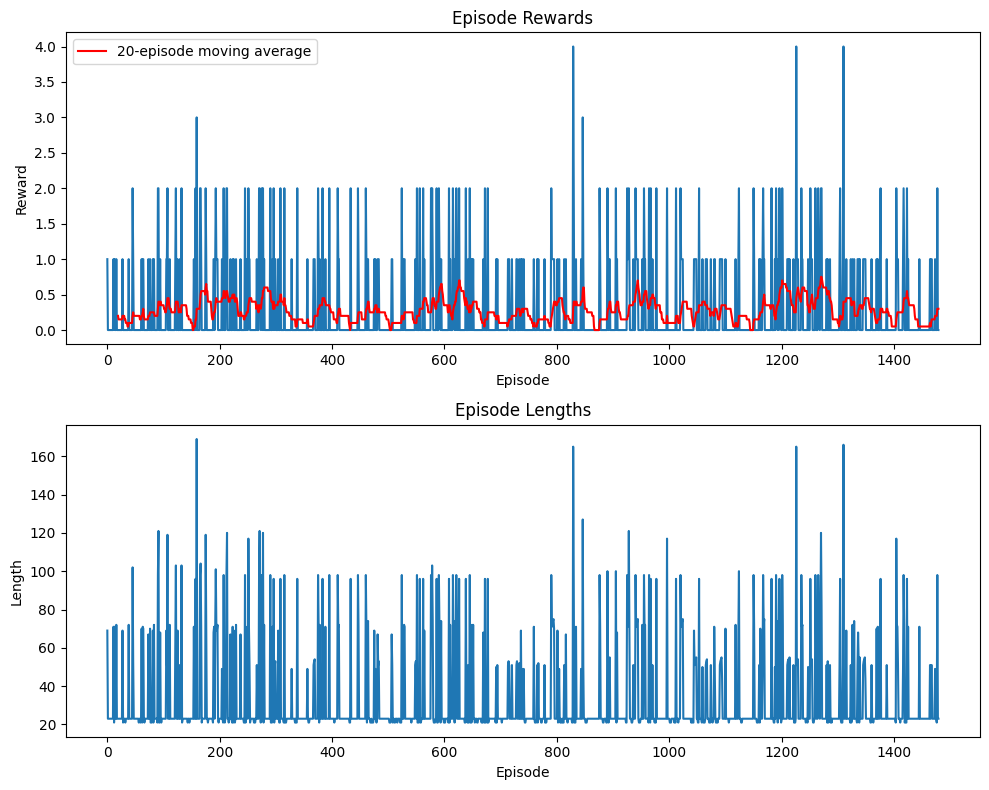

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 0.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 177      |
|    time_elapsed     | 278      |
|    total_timesteps  | 49605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00834  |
|    n_updates        | 9901     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.6     |
|    ep_rew_mean      | 0.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 177      |
|    time_elapsed     | 280      |
|    total_timesteps  | 49818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00758  |
|    n_updates      

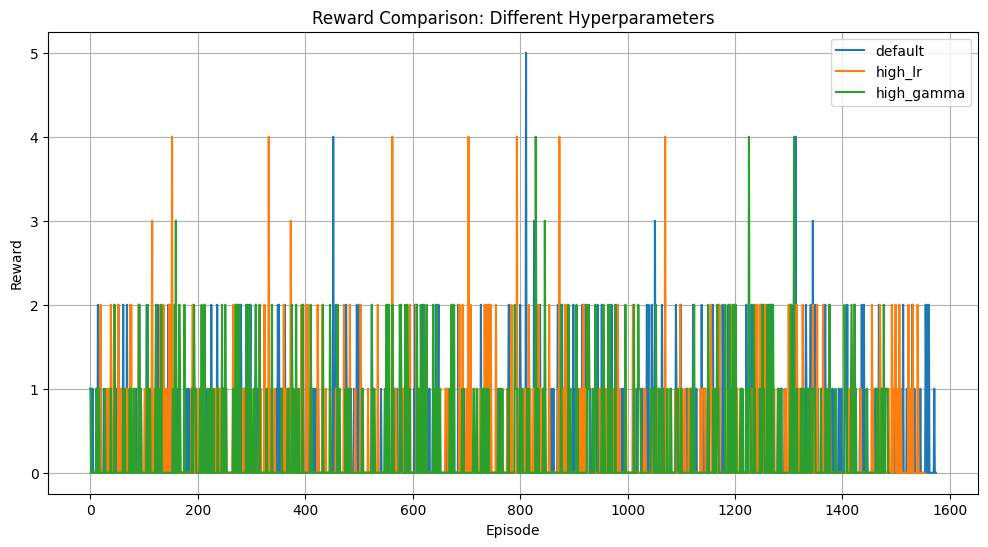

In [15]:
# Run hyperparameter tuning
# Note: This will take some time to run
hp_results = hyperparameter_tuning(env_id, timesteps=50000)  # Uncomment to run

## 8. Conclusion

In this notebook, we've implemented a DQN agent to play Atari games (or CartPole as a fallback) using Stable Baselines 3. We've covered:

1. Setting up the environment with proper wrappers and error handling
2. Training a DQN agent with appropriate policy
3. Evaluating the trained agent's performance
4. Comparing different policies (when applicable)
5. Tuning hyperparameters to improve performance

Key findings:
- For Atari games, CNN policies typically outperform MLP policies due to their ability to process image data
- Hyperparameter tuning can significantly impact agent performance
- The agent learns to play the game effectively with sufficient training time

For best results, increase the number of training timesteps and experiment with different hyperparameter configurations.

In [47]:
model_name = 'dqn_model_default_run.zip'
model = DQN.load(model_name)
env_id = "BreakoutNoFrameskip-v4"
rewards, lengths = evaluate_agent(model, env_id, num_episodes=40)

#rewards, lengths = evaluate_agent(model, env_id, num_episodes=20)

/Users/mugishakennykevin/summative_2/.venv/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 7.06GB > 3.87GB
  warnings.warn(


Starting episode 1/40
Episode 1 finished with reward: 2.0, length: 82
Starting episode 2/40
Episode 2 finished with reward: 2.0, length: 101
Starting episode 3/40
Episode 3 finished with reward: 2.0, length: 84
Starting episode 4/40
Episode 4 finished with reward: 4.0, length: 142
Starting episode 5/40
Episode 5 finished with reward: 3.0, length: 94
Starting episode 6/40
Episode 6 finished with reward: 4.0, length: 193
Starting episode 7/40
Episode 7 finished with reward: 2.0, length: 82
Starting episode 8/40
Episode 8 finished with reward: 3.0, length: 130
Starting episode 9/40
Episode 9 finished with reward: 1.0, length: 53
Starting episode 10/40
Episode 10 finished with reward: 3.0, length: 93
Starting episode 11/40
Episode 11 finished with reward: 6.0, length: 213
Starting episode 12/40
Episode 12 finished with reward: 3.0, length: 179
Starting episode 13/40
Episode 13 finished with reward: 2.0, length: 77
Starting episode 14/40
Episode 14 finished with reward: 0.0, length: 23
Star